In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import db_connection as db

# load your cleaned flight log
df = db.read_db("flights_cleaned")
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
raw_dataset = df[["gps_altitude_m","speed_km/s","climb_m","climb_m(delta)","climb_rate_m/s","bearing","delta_bearing","glide_ratio","elapsed_time","temp","pressure","humidity","dew_point","wind_speed","wind_deg"]]
dataset = raw_dataset.copy()
dataset.head()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
0,2083,27.164986,-2.0,0.0,-2.0,11,3.0,3.772915,17.0,25.62,1008.0,35.0,9.04,0.66,75.0
1,2082,28.697530,-3.0,0.0,-3.0,21,10.0,2.657179,18.0,25.62,1008.0,35.0,9.04,0.66,75.0
2,2080,43.046289,-2.0,0.0,-2.0,21,0.0,5.978651,19.0,25.62,1008.0,35.0,9.04,0.66,75.0
3,2079,34.146645,-1.0,-14.0,-1.0,38,17.0,9.485179,20.0,25.62,1008.0,35.0,9.04,0.66,75.0
4,2078,34.146634,0.0,-14.0,0.0,38,0.0,0.000000,21.0,25.62,1008.0,35.0,9.04,0.66,75.0


In [3]:
dataset.describe()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
count,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06,1.552164e+06
mean,2.517768e+03,4.990280e+01,2.011514e-02,5.513045e-01,1.975983e-02,1.450012e+02,9.961753e+00,7.455871e+00,1.358669e+04,3.093591e+01,1.007325e+03,2.692119e+01,9.116711e+00,3.264907e+00,2.300101e+02
std,6.624665e+02,1.591653e+01,2.137012e+00,3.642395e+01,2.085181e+00,9.039138e+01,1.312044e+01,5.867016e+00,8.037768e+03,3.494276e+00,2.377966e+00,7.386355e+00,3.039939e+00,1.376462e+00,1.140969e+02
min,1.600000e+01,2.560542e+00,-1.300000e+01,-1.650000e+02,-6.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.960000e+01,1.001000e+03,9.000000e+00,-2.230000e+00,0.000000e+00,0.000000e+00
25%,2.059000e+03,3.952668e+01,-1.000000e+00,-2.700000e+01,-1.000000e+00,6.900000e+01,2.000000e+00,3.029444e+00,6.706000e+03,2.863000e+01,1.006000e+03,2.200000e+01,7.000000e+00,2.300000e+00,1.900000e+02
50%,2.520000e+03,5.115990e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.470000e+02,6.000000e+00,6.436344e+00,1.340300e+04,3.061000e+01,1.007000e+03,2.700000e+01,9.310000e+00,3.270000e+00,2.630000e+02
75%,2.967000e+03,6.156538e+01,1.000000e+00,2.700000e+01,1.000000e+00,2.000000e+02,1.300000e+01,1.141784e+01,2.008000e+04,3.314000e+01,1.009000e+03,3.200000e+01,1.124000e+01,4.180000e+00,3.290000e+02
max,8.500000e+03,9.949969e+01,1.300000e+01,1.650000e+02,6.500000e+00,3.570000e+02,1.800000e+02,2.869482e+01,3.646100e+04,4.111000e+01,1.015000e+03,5.800000e+01,2.225000e+01,8.700000e+00,3.600000e+02


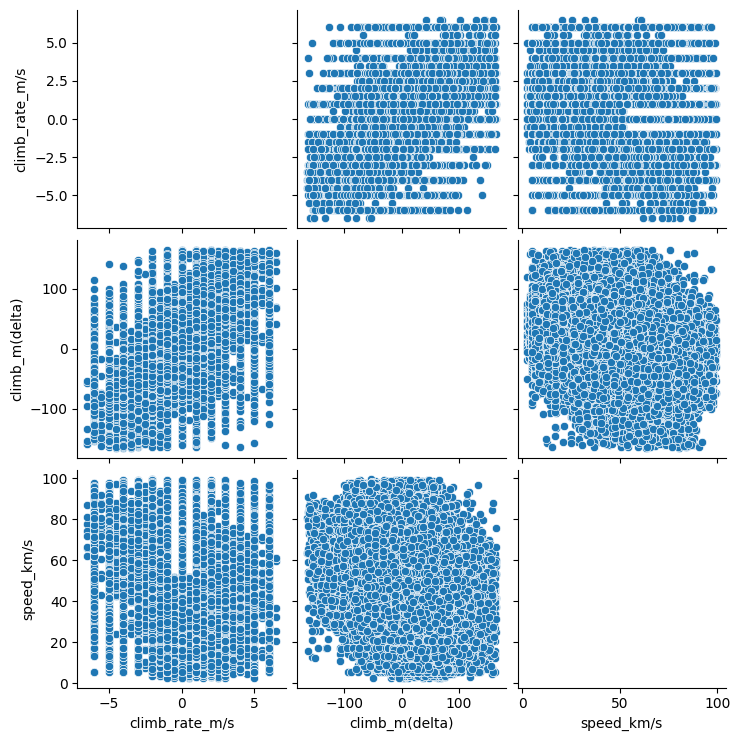

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["climb_rate_m/s", "climb_m(delta)", "speed_km/s"]], diag_kind="zone")

Let's also check the overall statistics. Note how each feature covers a very different range:

In [5]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gps_altitude_m,1241731.0,2517.323840,662.227477,16.000000,2058.000000,2519.000000,2966.000000,8500.000000
speed_km/s,1241731.0,49.909959,15.911543,2.560542,39.526670,51.165915,61.571043,99.499694
climb_m,1241731.0,0.020289,2.137364,-13.000000,-1.000000,0.000000,1.000000,13.000000
climb_m(delta),1241731.0,0.555285,36.422674,-165.000000,-27.000000,1.000000,27.000000,165.000000
climb_rate_m/s,1241731.0,0.019902,2.085613,-6.500000,-1.000000,0.000000,1.000000,6.500000
bearing,1241731.0,144.972853,90.390344,0.000000,69.000000,147.000000,200.000000,357.000000
delta_bearing,1241731.0,9.953033,13.094734,0.000000,2.000000,6.000000,13.000000,180.000000
glide_ratio,1241731.0,7.455160,5.867421,0.000000,3.026436,6.436632,11.407814,28.694822
elapsed_time,1241731.0,13586.935183,8038.541703,1.000000,6707.000000,13405.000000,20080.000000,36461.000000
temp,1241731.0,30.936434,3.494949,19.600000,28.630000,30.610000,33.140000,41.110000


In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# train_labels = train_features.pop("climb_rate_m/s")
# test_labels = test_features.pop("climb_rate_m/s")

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
gps_altitude_m,2517.323840,662.227477
speed_km/s,49.909959,15.911543
climb_m,0.020289,2.137364
climb_m(delta),0.555285,36.422674
climb_rate_m/s,0.019902,2.085613
bearing,144.972853,90.390344
delta_bearing,9.953033,13.094734
glide_ratio,7.455160,5.867421
elapsed_time,13586.935183,8038.541703
temp,30.936434,3.494949


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 2517.324    49.91      0.02      0.555     0.02    144.973     9.953
      7.455 13586.936    30.936  1007.325    26.923     9.118     3.265
    229.993]]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 2829.      47.79     1.      11.       1.     192.      12.      13.28
  22226.      31.96  1005.      30.      12.23     3.74     8.  ]]

Normalized: [[ 0.47 -0.13  0.46  0.29  0.47  0.52  0.16  0.99  1.07  0.29 -0.98  0.42
   1.02  0.35 -1.95]]


In [18]:
vario = np.array(train_features["climb_rate_m/s"])

vario_normalizer = layers.Normalization(input_shape=[1,], axis=None)
vario_normalizer.adapt(vario)
vario_model = tf.keras.Sequential([
    vario_normalizer,
    layers.Dense(units=1)
])

vario_model.summary()

/Users/serkan/Documents/Projeler/Paragliding_Flight_Analyses/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [19]:
vario_model.predict(vario[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[ 0.272],
       [-0.006],
       [ 1.382],
       [ 0.549],
       [ 1.382],
       [-0.561],
       [-0.006],
       [-0.006],
       [-0.006],
       [-0.838]], dtype=float32)

In [20]:
vario_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [21]:
%%time
history = vario_model.fit(
    train_features["climb_rate_m/s"],
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

CPU times: user 2min 5s, sys: 20.1 s, total: 2min 25s
Wall time: 1min 41s


,loss,val_loss,epoch
5,0.013050,0.009028,5
6,0.013374,0.022029,6
7,0.013459,0.012914,7
8,0.013157,0.002142,8
9,0.013378,0.016484,9


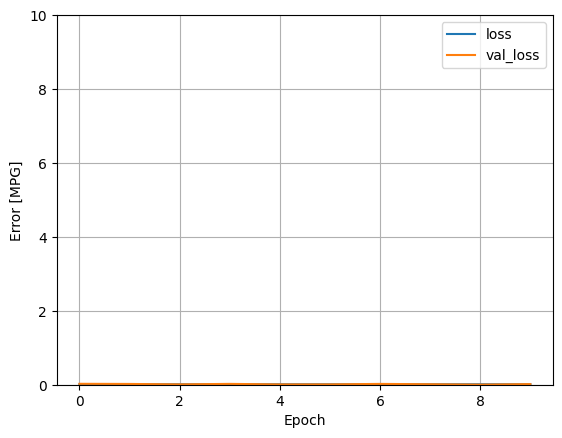

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

Collect the results on the test set for later:

In [24]:
test_results = {}

test_results['vario_model'] = vario_model.evaluate(
    test_features['climb_rate_m/s'],
    test_labels, verbose=0)

In [25]:
x = tf.linspace(0.0, 250, 251)
y = vario_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


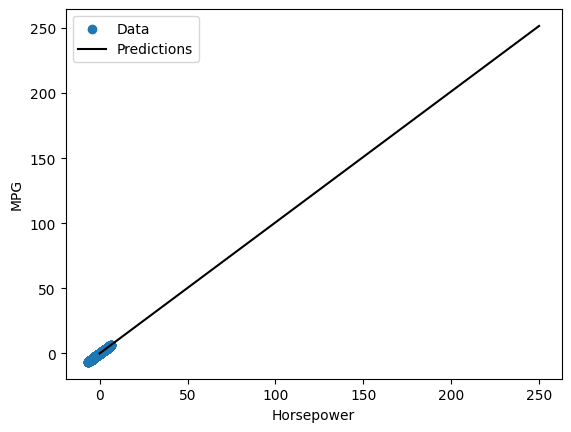

In [26]:
def plot_vario(x, y):
  plt.scatter(train_features['climb_rate_m/s'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_vario(x, y)

In [27]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [28]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[-0.079],
       [-3.889],
       [ 0.535],
       [-0.103],
       [-0.771],
       [ 0.699],
       [-1.824],
       [-4.642],
       [-0.166],
       [-0.599]], dtype=float32)

In [29]:
linear_model.layers[1].kernel

<Variable path=sequential_2/dense_2/kernel, shape=(15, 1), dtype=float32, value=[[-0.263]
 [ 0.544]
 [ 0.035]
 [-0.185]
 [-0.091]
 [-0.459]
 [-0.28 ]
 [ 0.522]
 [ 0.437]
 [-0.463]
 [-0.456]
 [-0.413]
 [-0.175]
 [ 0.087]
 [ 0.256]]>

In [30]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [31]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2min 8s, sys: 19.5 s, total: 2min 27s
Wall time: 1min 43s


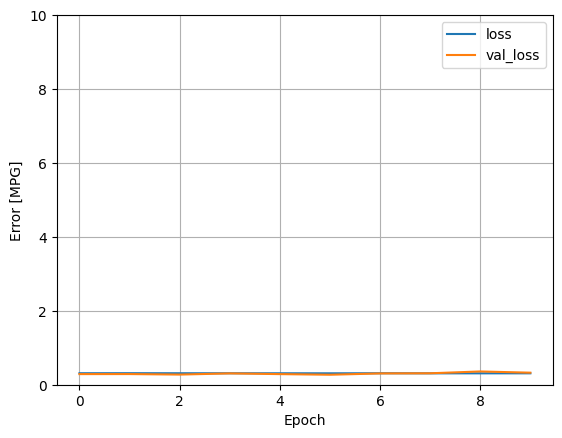

In [46]:
plot_loss(history)

In [47]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [48]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [49]:
dnn_vario_model = build_and_compile_model(vario_normalizer)

In [50]:
dnn_vario_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras `Model.fit`:

In [52]:
%%time
history = dnn_vario_model.fit(
    train_features['climb_rate_m/s'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 17.2 s, sys: 2.32 s, total: 19.5 s
Wall time: 13.8 s


This model does slightly better than the linear single-input `horsepower_model`:

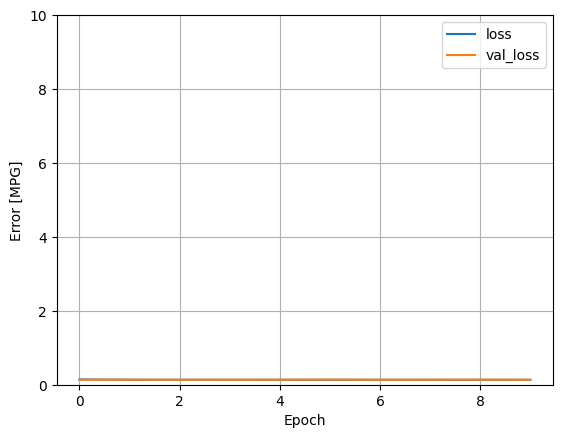

In [53]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [54]:
x = tf.linspace(0.0, 250, 251)
y = dnn_vario_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


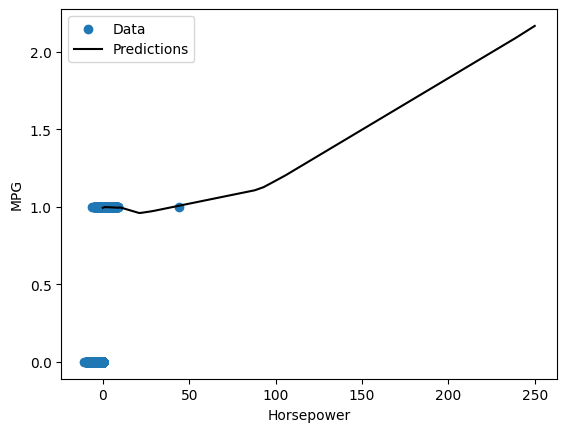

In [55]:
plot_vario(x, y)

Collect the results on the test set for later:

In [57]:
test_results['dnn_vario_model'] = dnn_vario_model.evaluate(
    test_features['climb_rate_m/s'], test_labels,
    verbose=0)

In [58]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (10, 15)               │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (128.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31 (128.00 B)

In [59]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 17.6 s, sys: 2.38 s, total: 20 s
Wall time: 14.4 s


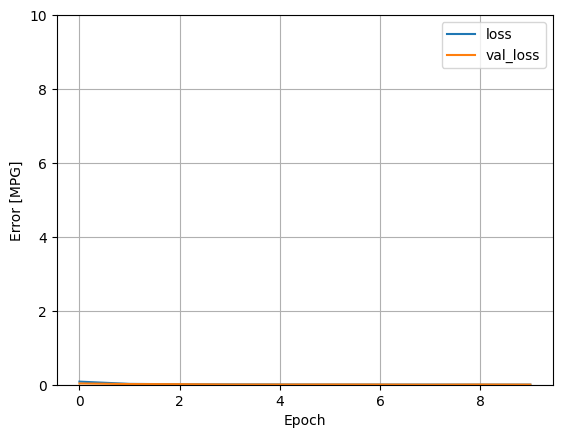

In [60]:
plot_loss(history)

In [61]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [62]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
vario_model,0.284044
linear_model,0.327001
dnn_vario_model,0.134527
dnn_model,0.002509


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


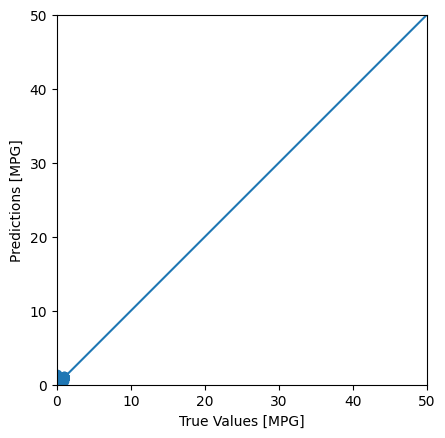

In [63]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

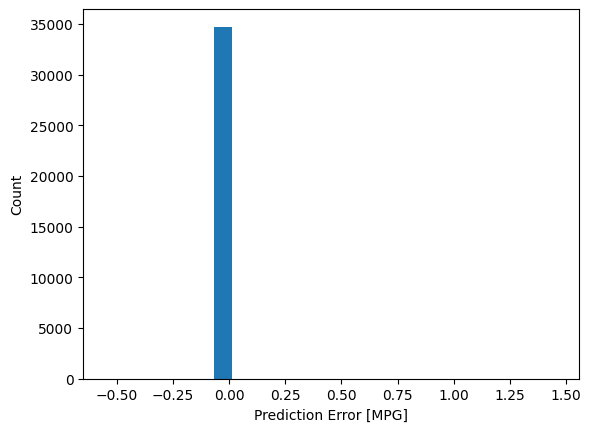

In [64]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [65]:
dnn_model.save('dnn_model.keras')

In [66]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [67]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
vario_model,0.284044
linear_model,0.327001
dnn_vario_model,0.134527
dnn_model,0.002509
reloaded,0.002509
